In [39]:
import os
import sys
import time
from dataclasses import dataclass
import urllib.request as request 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from pathlib import Path
from poxVisionDetection.constants import *
from poxVisionDetection.utils.common import read_yaml,create_directory
from poxVisionDetection import CustomException,logging
import matplotlib.pyplot as plt

In [2]:
# os.chdir('d:\\codes\\DeepLearning_Proj\\poxVision_detection\\research')

In [3]:
os.chdir('../')
%pwd

'd:\\codes\\DeepLearning_Proj\\poxVision_detection'

In [15]:
@dataclass(frozen = True)
class TrainingConfig:
    root_dir                    : Path
    training_model_path         : Path
    updated_base_model_path     : Path
    training_data               : Path
    params_epochs               : int
    params_batch_size           : int
    params_is_augmentation      : bool
    params_image_size           : list

@dataclass(frozen = True)
class PrepareCallbacksConfig:
    root_dir                    : Path
    tensorboard_root_log_dir    : Path
    checkpoint_model_filepath   : Path

In [16]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath               = CONFIG_FILE_PATH,
        params_filepath               = PARAMS_FILE_PATH):

        self.config                   = read_yaml(config_filepath)
        self.params                   = read_yaml(params_filepath)

        create_directory([self.config.artifacts_root])

    def get_prepare_callbacks_config(self) -> PrepareCallbacksConfig:
        config                        = self.config.prepare_callbacks
        model_ckpt_dir                = os.path.dirname(config.checkpoint_model_filepath)

        create_directory([
            Path(model_ckpt_dir),
            Path(config.tensorboard_root_log_dir)
        ])

        prepare_callback_config       = PrepareCallbacksConfig(
            root_dir                  = Path(config.root_dir),
            tensorboard_root_log_dir  = Path(config.tensorboard_root_log_dir),
            checkpoint_model_filepath = Path(config.checkpoint_model_filepath)
        )

        return prepare_callback_config
    
    def get_training_config(self) -> TrainingConfig:
        training                      = self.config.training
        prepare_base_model            = self.config.prepare_base_model
        params                        = self.params

        training_data = os.path.join(self.config.data_ingestion.unzip_dir, 'poxVisionDataSet')
        create_directory([Path(training.root_dir)])

        training_config               = TrainingConfig(
            root_dir                  = Path(training.root_dir),
            training_model_path       = Path(training.trained_model_path),
            updated_base_model_path   = Path(prepare_base_model.updated_base_model_path),
            training_data             = Path(training_data),
            params_epochs             = params.EPOCHS,
            params_batch_size         = params.BATCH_SIZE,
            params_is_augmentation    = params.AUGMENTATION,
            params_image_size         = params.IMAGE_SIZE
        )

        return training_config

In [19]:
class PrepareCallback:
    def __init__(self, config : PrepareCallbacksConfig):
        self.config = config

    @property
    def _create_tb_callbacks(self):
        timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
        tb_running_log_dir = os.path.join(
            self.config.tensorboard_root_log_dir,
            f'tb_log_at_{timestamp}'
        )
        return tf.keras.callbacks.TensorBoard(log_dir = tb_running_log_dir)
    
    @property
    def _create_ckpt_callbacks(self):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath       = 'artifacts\prepare_callbacks\checkpoint_dir\model.h5',
            save_best_only = True
        )
    
    def get_tb_ckpt_callbacks(self):
        return [
            self._create_tb_callbacks,
            self._create_ckpt_callbacks
        ]

In [44]:
class Training:
    def __init__(self, config : TrainingConfig):
        self.config = config

    def get_base_model(self):
        # LOADING THE UPDATED BASE MODEL
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )

    def training_valid_generator(self):
        valid_datagenerator         = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function     = preprocess_input,
            shear_range                = 0.2,
            zoom_range                 = 0.2,
            validation_split           = 0.4,
        )

        # THIS GENERATOR HAS BEEN CREATED FOR THE TRAINING
        self.train_generator        = valid_datagenerator.flow_from_directory(
            directory                   = self.config.training_data,
            target_size                 = self.config.params_image_size[:-1],
            batch_size                  = self.config.params_batch_size,
            class_mode                  = 'categorical',
            subset                      = 'training',
        )

        # THIS GENERATOR HAS BEEN CREATED FOR THE VALIDATION
        self.valid_generator        = valid_datagenerator.flow_from_directory(
            directory                  = self.config.training_data,
            target_size                = self.config.params_image_size[:-1],
            batch_size                 = self.config.params_batch_size,
            class_mode                 = 'categorical',  
            subset                     = 'validation',
        )

    def train(self, callback_list : list):
        trained_model = self.model.fit(

            self.train_generator,

            epochs                       = self.config.params_epochs,
            steps_per_epoch              = 3,

            validation_data              = self.valid_generator,
            validation_steps             = 2,

            callbacks                    = callback_list
        )

        self.save_model(
            path                     = self.config.training_model_path,
            model                    = self.model
        )
        
        return trained_model

    def train_model_status(self, callback_list: list):
        trained_model = self.train(callback_list)
        plt.plot(trained_model.history['accuracy'])
        plt.plot(trained_model.history['val_accuracy'])
        plt.axis(ymin=0.0,ymax=1)
        plt.grid()
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train','validation'])
        plt.show()

    @staticmethod
    def save_model(path : Path, model : tf.keras.Model):
        model.save(path)

[2023-11-13 00:58:06,045] 31 root - INFO - YAML FILE {path_to_yaml} LOADED SUCCESSFULLY 
[2023-11-13 00:58:06,047] 31 root - INFO - YAML FILE {path_to_yaml} LOADED SUCCESSFULLY 
[2023-11-13 00:58:06,048] 47 root - INFO - CREATED DIRECTORY AT : artifacts
[2023-11-13 00:58:06,049] 47 root - INFO - CREATED DIRECTORY AT : artifacts\prepare_callbacks\checkpoint_dir
[2023-11-13 00:58:06,051] 47 root - INFO - CREATED DIRECTORY AT : artifacts\prepare_callbacks\tensorflow_log_dir
[2023-11-13 00:58:06,052] 47 root - INFO - CREATED DIRECTORY AT : artifacts\training
Found 138 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Epoch 1/6
3/3 [==============================] - 10s 3s/step - loss: 0.7411 - accuracy: 0.6500 - val_loss: 0.7563 - val_accuracy: 0.4750
Epoch 2/6
3/3 [==============================] - 7s 3s/step - loss: 0.4260 - accuracy: 0.8500 - val_loss: 0.7357 - val_accuracy: 0.5750
Epoch 3/6
3/3 [==============================] - 7s 3s/step - loss: 0.3988 - accuracy

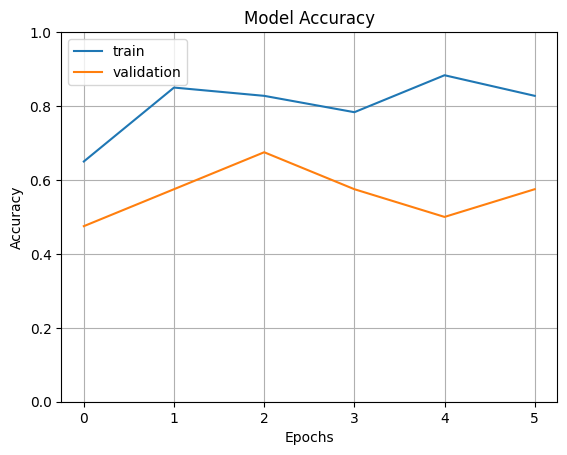

In [45]:
try:
    config                        = ConfigurationManager()
    prepare_callbacks_config      = config.get_prepare_callbacks_config()
    prepare_callbacks             = PrepareCallback(config = prepare_callbacks_config)
    callback_list                 = prepare_callbacks.get_tb_ckpt_callbacks()
    training_config               = config.get_training_config()
    training                      = Training(config = training_config)

    training.get_base_model()
    training.training_valid_generator()

    training.train_model_status(
        callback_list=callback_list
    )

except Exception as e:
    logging.exception(CustomException(e,sys))